# Humanoids in Habitat
This tutorial covers how to initialize and interact with humanoids in Habitat. Humanoids are represented as articulated agents with a deformable mesh. As such, they can interact in the environment the same way as describe in the ao_tutorial. While you can update the humanoid articulations freely, you may want to generate realistic motions. For this, we provide a set of controllers that update the humanoid joints to represent realistic behaviors. In this tutorial we will cover:
- How to initialize a humanoid in the scene
- Using humanoid controllers
- Executing humanoid actions

In [1]:

import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
import habitat
import os
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf
from habitat.articulated_agent_controllers import (
    HumanoidRearrangeController,
    HumanoidSeqPoseController,
)
from habitat.config.default_structured_configs import HumanoidJointActionConfig, HumanoidPickActionConfig



/home/ramasamyn/miniconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pybullet build time: May 31 2024 15:30:11


In [2]:
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # # Set up an example scene
    sim_cfg.scene = "data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json"
    sim_cfg.scene_dataset = "data/hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json"
    sim_cfg.additional_object_paths = ['data/objects/ycb/configs/']
    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()   
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

# Initializing humanoids in the scene
As any articulated agent, humanoids are defined in Habitat via a URDF file. Our current URDF is based on the SMPL-X body model, with 54 rotation joints indicating relative rotation of different body parts. You can find the joint information [here](https://github.com/vchoutas/smplx/blob/main/smplx/joint_names.py#L19). Every human body will have its own URDF, and we provide scripts to generate new URDFs for arbitrary body shapes.
We use `KinematicHumanoid` to represent humanoids, which allows to control the humanoid kinematically. 

Additionally, every humanoid has a motion_data file, which contains information about the joint rotations to enable the humanoid to walk or reach to objects. We will be using this file later.

We will start defining an environment and adding a humanoid agent. As shown in the ao_tutorial, we need to define the action space. For humanoids we provide a basic action space, called HumanoidJointAction which kinematically updates the humanoid joints.

In [3]:

# # Define the agent configuration

main_agent_config = AgentConfig()
urdf_path = "data/hab3_bench_assets/humanoids/female_0/female_0.urdf"
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "KinematicHumanoid"
main_agent_config.motion_data_path = "data/hab3_bench_assets/humanoids/female_0/female_0_motion_data_smplx.pkl"



# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why giving the sensors these names
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
agent_dict = {"main_agent": main_agent_config}



In [4]:
# Define the actions

action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig()
}
env = init_rearrange_env(agent_dict, action_dict)


2024-06-13 15:38:08,302 Initializing dataset RearrangeDataset-v0
2024-06-13 15:38:08,303 initializing sim RearrangeSim-v0
[15:38:08:357346]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[15:38:08:357402]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[15:38:08:357408]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[15:38:08:357412]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAt

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.171.04
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


When resetting the environment, the humanoid is standing by default

MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


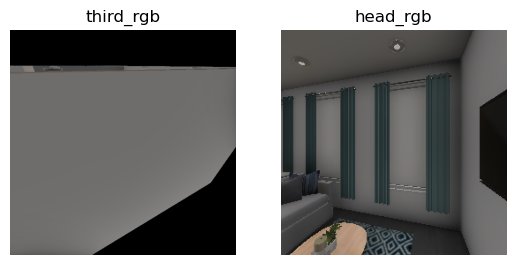

In [5]:
obs = env.reset()
_, ax = plt.subplots(1,len(obs.keys()))

for ind, name in enumerate(obs.keys()):
    ax[ind].imshow(obs[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

Like other articulated agents, we can rotate and move their base.

In [6]:
sim = env.sim
observations = []
num_iter = 100
pos_delta = mn.Vector3(0.02,0,0)
rot_delta = np.pi / (8 * num_iter)
art_agent = sim.articulated_agent
sim.reset()
# set_fixed_camera(sim)
for _ in range(num_iter):
    # TODO: this actually seems to give issues...
    art_agent.base_pos = art_agent.base_pos + pos_delta
    art_agent.base_rot = art_agent.base_rot + rot_delta
    sim.step({})
    observations.append(sim.get_sensor_observations())


vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 


We can also use the HumanoidJointAction to sample new rotations and joints

In [7]:
# TODO: maybe we can make joint_action a subclass of dict, and have a custom function for it
import random
def random_rotation():
    random_dir = mn.Vector3(np.random.rand(3)).normalized()
    random_angle = random.random() * np.pi
    random_rat = mn.Quaternion.rotation(mn.Rad(random_angle), random_dir)
    return random_rat
def custom_sample_humanoid():
    base_transform = mn.Matrix4() 
    random_rot = random_rotation()
    offset_transform = mn.Matrix4.from_(random_rot.to_matrix(), mn.Vector3())
    joints = []
    num_joints = 54
    for _ in range(num_joints):
        Q = random_rotation()
        joints = joints + list(Q.vector) + [float(Q.scalar)]
    offset_trans = list(np.asarray(offset_transform.transposed()).flatten())
    base_trans = list(np.asarray(base_transform.transposed()).flatten())
    random_vec = joints + offset_trans + base_trans
    return {
        "human_joints_trans": random_vec
    }
    

[000060948eb2b580] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.


In [8]:
# We can now call the defined actions
observations = []
num_iter = 40
env.reset()
for _ in range(num_iter):
    params = custom_sample_humanoid()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

QObject::moveToThread: Current thread (0x7a6758000dc0) is not the object's thread (0x7a67580fe0f0).
Cannot move to target thread (0x7a6758000dc0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/ramasamyn/miniconda3/envs/habitat/lib/python3.9/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc.



Encoding the video: robot_tutorial_video.mp4 


# Humanoid Controllers
While you can manually set the agent joints and rotations, or train a policy to set them, in many cases you may just be interested in generating realistic motions, either coming from a separate model or from motion capture data. For this, we introduce the HumanoidControllers, which are helper classes to calculate humanoid poses. We currently provide two of them, which we cover here.

## HumanoidSeqPoseController
This pose controller is designed to play a motion sequence, which can come from a model or a motion capture file. For this, you will need a `.pkl` motion file containing a sequence of poses. You can find [here](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-lab/habitat/articulated_agents/humanoids#sequentialposecontroller) how to convert a motion file with a format commonly used in SMPL-X (including AMASS or Motion Diffusion Models) into a `.pkl` which can be consumed in by the HumanoidSeqPoseController.

### Convert Motion File

In [9]:
from habitat.utils.humanoid_utils import MotionConverterSMPLX
PATH_TO_URDF = "data/humanoids/humanoid_data/female_2/female_2.urdf"
PATH_TO_MOTION_NPZ = "data/humanoids/humanoid_data/walk_motion/CMU_10_04_stageii.npz"
convert_helper = MotionConverterSMPLX(urdf_path=PATH_TO_URDF)
convert_helper.convert_motion_file(
    motion_path=PATH_TO_MOTION_NPZ,
    output_path=PATH_TO_MOTION_NPZ.replace(".npz", ""),
)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
pelvisb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_hipb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_kneeb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp

### Initialize Controller

In [10]:
env.reset()
motion_path = "data/humanoids/humanoid_data/walk_motion/CMU_10_04_stageii.pkl" 
# We define here humanoid controller
humanoid_controller = HumanoidSeqPoseController(motion_path)


# Because we want the humanoid controller to generate a motion relative to the current agent, we need to set
# the reference pose
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
humanoid_controller.apply_base_transformation(env.sim.articulated_agent.base_transformation)


### Get pose sequence

In [11]:
observations = []
for _ in range(humanoid_controller.humanoid_motion.num_poses):
    # These computes the current pose and calculates the next pose
    humanoid_controller.calculate_pose()
    humanoid_controller.next_pose()
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

[0000650d2049a580] main libvlc error: D-Bus error: Message recipient disconnected from message bus without replying


Encoding the video: robot_tutorial_video.mp4 


### HumanoidRearrangeController
The second controller we provide is used to navigate and interact with objects in the environment. 

In [12]:
# As before, we first define the controller, here we use a special motion file we provide for each agent.
motion_path = "data/hab3_bench_assets/humanoids/female_0/female_0_motion_data_smplx.pkl" 
# We define here humanoid controller
humanoid_controller = HumanoidRearrangeController(motion_path)

[00005b6487d3d580] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.


We can use this controller to generate motion to walk to a given direction

In [13]:
# We reset the controller
env.reset()
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
observations = []
print(env.sim.articulated_agent.base_pos)
for _ in range(100):
    # This computes a pose that moves the agent to relative_position
    relative_position = env.sim.articulated_agent.base_pos + mn.Vector3(0,0,1)
    humanoid_controller.calculate_walk_pose(relative_position)
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

QObject::moveToThread: Current thread (0x74a358000dc0) is not the object's thread (0x74a3580fe0f0).
Cannot move to target thread (0x74a358000dc0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/ramasamyn/miniconda3/envs/habitat/lib/python3.9/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc.



Vector(-2.99427, 0.180179, 0.466785)
Encoding the video: robot_tutorial_video.mp4 


The controller can also be used to reach different positions with the hand

In [14]:
# We reset the controller
env.reset()
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
observations = []
print(env.sim.articulated_agent.base_pos)

# Get the hand pose
offset =  env.sim.articulated_agent.base_transformation.transform_vector(mn.Vector3(0, 0.3, 0))
hand_pose = env.sim.articulated_agent.ee_transform(0).translation + offset
for _ in range(100):
    # This computes a pose that moves the agent to relative_position
    hand_pose = hand_pose + mn.Vector3((np.random.rand(3) - 0.5) * 0.1)
    humanoid_controller.calculate_reach_pose(hand_pose, index_hand=0)
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

[000064d76e8d5580] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
QObject::moveToThread: Current thread (0x75692c000dc0) is not the object's thread (0x75692c0fe0f0).
Cannot move to target thread (0x75692c000dc0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/ramasamyn/miniconda3/envs/habitat/lib/python3.9/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc.



Vector(-0.546164, 0.180179, -6.57484)
Encoding the video: robot_tutorial_video.mp4 


# Executing Humanoid Actions
While you can use controllers to animate the humanoids, we also provide a set of actions that control the humanoid to navigate around the scene or pick and place objects.

In [15]:
# Define the actions


action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig(),
    "humanoid_navigate_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
                                                      motion_control="human_joints",
                                                      spawn_max_dist_to_obj=1.0),
    "humanoid_pick_obj_id_action": HumanoidPickActionConfig(type="HumanoidPickObjIdAction")
    
}
env = init_rearrange_env(agent_dict, action_dict)

2024-06-13 15:38:17,763 Initializing dataset RearrangeDataset-v0
2024-06-13 15:38:17,765 initializing sim RearrangeSim-v0
[15:38:17:782878]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[15:38:17:782935]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[15:38:17:782940]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[15:38:17:782944]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAt

We can now navigate to a target object

In [16]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)
# TODO: unoccluded object did not work
# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("humanoid_navigate_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    
# Wait
for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))

# Pick object
observations.append(env.step(action_dict))
for _ in range(100):
    
    action_dict = {"action": ("humanoid_pick_obj_id_action"), "action_args": {"humanoid_pick_obj_id": obj_id}}
    observations.append(env.step(action_dict)) 
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

[0000579c19a4e580] main libvlc error: D-Bus error: Message recipient disconnected from message bus without replying
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


003_cracker_box_:0000 is in Vector(-5.55847, 0.95434, -2.40326)
Encoding the video: robot_tutorial_video.mp4 


[00005598d45c9580] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
QObject::moveToThread: Current thread (0x71ad64000dc0) is not the object's thread (0x71ad640fe0f0).
Cannot move to target thread (0x71ad64000dc0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/ramasamyn/miniconda3/envs/habitat/lib/python3.9/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc.

